# Stock price prediction

In [1075]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.stats import kstest
from sklearn.preprocessing import MinMaxScaler
from statsforecast import StatsForecast
from statsforecast.models import (TBATS, AutoARIMA, AutoRegressive, AutoTheta,
                                  HistoricAverage, Holt)
from torch.utils.data import DataLoader, TensorDataset

In [1076]:
sns.set_style("darkgrid")
warnings.simplefilter(action='ignore', category=FutureWarning)
set_matplotlib_formats('svg')

## Data

In [1161]:
df = pd.read_csv("MSFT.csv")
df.Date = pd.to_datetime(df.Date)
open_price = df['Open'].values.reshape(-1, 1)

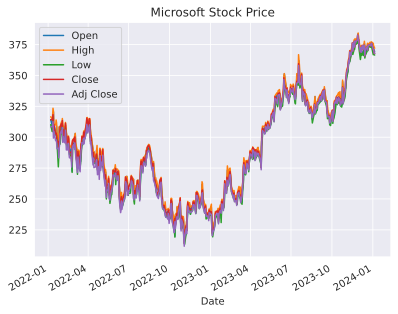

In [1079]:
df.drop("Volume", axis=1).plot(x="Date")
plt.title("Microsoft Stock Price")
plt.show()

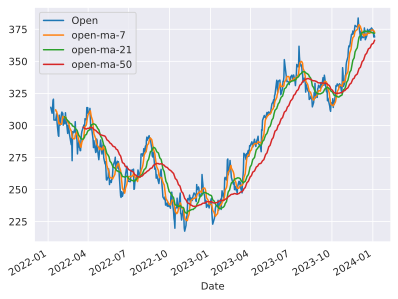

In [1080]:
df["open-ma-7"] = df["Open"].rolling(window=7).mean()
df["open-ma-21"] = df["Open"].rolling(window=21).mean()
df["open-ma-50"] = df["Open"].rolling(window=50).mean()

df[["Date", "Open", "open-ma-7", "open-ma-21", "open-ma-50"]].plot(x="Date")
plt.show()

In [1081]:
log_returns = np.log(open_price[:-1] / open_price[1:])

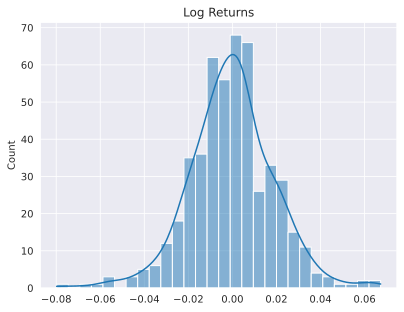

In [1082]:
sns.histplot(log_returns, kde=True, legend=False)
plt.title("Log Returns")
plt.show()

In [612]:
kstest(((log_returns - log_returns.mean()) / log_returns.std()).flatten(), 'norm')

KstestResult(statistic=0.052704262517795586, pvalue=0.11997840934938397, statistic_location=0.3246994842511452, statistic_sign=1)

### Preprocessing

In [697]:
test_size = 0.2
test_index = int(len(open_price) * (1 - test_size))

train, test = open_price[:test_index], open_price[test_index:]

In [699]:
scaler = MinMaxScaler().fit(train)

train = scaler.transform(train).flatten()
test = scaler.transform(test).flatten()

In [950]:
# function for creating a dataset with look back
def create_lookback_dataset(data, look_back=1):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_x.append(data[i:(i + look_back)])
        data_y.append(data[i + look_back])
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return np.reshape(data_x, (data_x.shape[0], data_x.shape[1], 1)), np.reshape(data_y, (data_y.shape[0], 1))

### Models

In [1031]:
class MyLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        out, _ = self.lstm(x, (h_0.detach(), c_0.detach()))
        out = self.linear(out[:, -1, :]) 
        return out
    

class MyGRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, _ = self.gru(x, (h0.detach()))
        out = self.linear(out[:, -1, :]) 
        return out

### Hypertuning

In [1028]:
def set_up_torch_data(look_back):
   train_x, train_y = map(lambda x: torch.from_numpy(x).type(torch.float32), create_lookback_dataset(train, look_back))
   train_dataset = TensorDataset(train_x, train_y)
   train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
   return train_loader

In [1032]:
epochs = 20

def lstm_objective(trial):
    look_back = trial.suggest_int('look_back', 10, 60)

    train_loader = set_up_torch_data(look_back)

    hidden_size = trial.suggest_int('hidden_size', 4, 15)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    lstm = MyLSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers)

    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(lstm.parameters(), lr=lr)

    epochs_losses = []  
    for _ in range(epochs):
        loss_ = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = lstm.forward(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            loss_ += loss.item()
        epochs_losses.append(loss_ / len(train_loader))

    return epochs_losses[-1]


def gru_objective(trial):
    look_back = trial.suggest_int('look_back', 10, 60)

    train_loader = set_up_torch_data(look_back) 

    hidden_size = trial.suggest_int('hidden_size', 4, 15)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    gru = MyGRU(1, hidden_size=hidden_size, num_layers=num_layers)

    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(gru.parameters(), lr=lr)

    epochs_losses = []
    for _ in range(epochs):
        loss_ = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = gru(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            loss_ += loss.item()
        epochs_losses.append(loss_ / len(train_loader))

    return epochs_losses[-1]

In [1020]:
print("LSTM hyperparameter tuning")
study = optuna.create_study(direction='minimize')
study.optimize(lstm_objective, n_trials=20)
print(study.best_params)
print(study.best_value)
print(study.best_trial)

[I 2024-01-17 22:15:35,291] A new study created in memory with name: no-name-f8ea0991-6201-48fb-89c9-da87bd8b3188


LSTM hyperparameter tuning


[I 2024-01-17 22:15:38,102] Trial 0 finished with value: 0.009147725709610515 and parameters: {'look_back': 46, 'hidden_size': 4, 'num_layers': 4, 'lr': 0.00044301013158735053}. Best is trial 0 with value: 0.009147725709610515.
[I 2024-01-17 22:15:39,894] Trial 1 finished with value: 0.0023762536636139785 and parameters: {'look_back': 43, 'hidden_size': 9, 'num_layers': 2, 'lr': 0.0022891465482010893}. Best is trial 1 with value: 0.0023762536636139785.
[I 2024-01-17 22:15:41,553] Trial 2 finished with value: 0.0036157621467050086 and parameters: {'look_back': 29, 'hidden_size': 11, 'num_layers': 2, 'lr': 0.0006255076008546143}. Best is trial 1 with value: 0.0023762536636139785.
[I 2024-01-17 22:15:44,393] Trial 3 finished with value: 0.003317516282240444 and parameters: {'look_back': 25, 'hidden_size': 15, 'num_layers': 5, 'lr': 0.0019865639819256317}. Best is trial 1 with value: 0.0023762536636139785.
[I 2024-01-17 22:15:46,139] Trial 4 finished with value: 0.0037327828315689908 and p

{'look_back': 56, 'hidden_size': 10, 'num_layers': 2, 'lr': 0.004541264043455761}
0.00162968639322275
FrozenTrial(number=5, state=TrialState.COMPLETE, values=[0.00162968639322275], datetime_start=datetime.datetime(2024, 1, 17, 22, 15, 46, 140654), datetime_complete=datetime.datetime(2024, 1, 17, 22, 15, 47, 798152), params={'look_back': 56, 'hidden_size': 10, 'num_layers': 2, 'lr': 0.004541264043455761}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'look_back': IntDistribution(high=60, log=False, low=10, step=1), 'hidden_size': IntDistribution(high=15, log=False, low=4, step=1), 'num_layers': IntDistribution(high=5, log=False, low=2, step=1), 'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None)}, trial_id=5, value=None)


In [1033]:
print("GRU hyperparameter tuning")
study = optuna.create_study(direction='minimize')
study.optimize(gru_objective, n_trials=20)
print(study.best_params)
print(study.best_value)
print(study.best_trial)

[I 2024-01-17 22:19:53,638] A new study created in memory with name: no-name-df935476-13ed-41a5-8187-8ca491f84465


GRU hyperparameter tuning


[I 2024-01-17 22:20:12,718] Trial 0 finished with value: 0.00151897816976998 and parameters: {'look_back': 36, 'hidden_size': 4, 'num_layers': 5, 'lr': 0.006795127233001239}. Best is trial 0 with value: 0.00151897816976998.
[I 2024-01-17 22:20:32,518] Trial 1 finished with value: 0.0018550634520816739 and parameters: {'look_back': 33, 'hidden_size': 4, 'num_layers': 5, 'lr': 0.005233947366698339}. Best is trial 0 with value: 0.00151897816976998.
[I 2024-01-17 22:20:54,761] Trial 2 finished with value: 0.001979243775839796 and parameters: {'look_back': 34, 'hidden_size': 13, 'num_layers': 5, 'lr': 0.0024221802204314135}. Best is trial 0 with value: 0.00151897816976998.
[I 2024-01-17 22:21:04,229] Trial 3 finished with value: 0.001612388607020915 and parameters: {'look_back': 36, 'hidden_size': 11, 'num_layers': 2, 'lr': 0.0014402872675376944}. Best is trial 0 with value: 0.00151897816976998.
[I 2024-01-17 22:21:29,099] Trial 4 finished with value: 0.0015424929197049803 and parameters: {

{'look_back': 36, 'hidden_size': 4, 'num_layers': 5, 'lr': 0.006795127233001239}
0.00151897816976998
FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.00151897816976998], datetime_start=datetime.datetime(2024, 1, 17, 22, 19, 53, 639953), datetime_complete=datetime.datetime(2024, 1, 17, 22, 20, 12, 718669), params={'look_back': 36, 'hidden_size': 4, 'num_layers': 5, 'lr': 0.006795127233001239}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'look_back': IntDistribution(high=60, log=False, low=10, step=1), 'hidden_size': IntDistribution(high=15, log=False, low=4, step=1), 'num_layers': IntDistribution(high=5, log=False, low=2, step=1), 'lr': FloatDistribution(high=0.01, log=True, low=0.0001, step=None)}, trial_id=0, value=None)


### Training best models

In [1039]:
lstm_lookback = 50
hidden_size = 10
num_layers = 2
best_lstm = MyLSTM(1, hidden_size, num_layers)

lr = 0.005
criterion = nn.MSELoss()
optimizer = optim.Adam(best_lstm.parameters(), lr=lr)

train_lstm_x, train_lstm_y = create_lookback_dataset(train, lstm_lookback)
train_lstm_x = torch.from_numpy(train_lstm_x).type(torch.float32)
train_lstm_y = torch.from_numpy(train_lstm_y).type(torch.float32)

lstm_loader = DataLoader(TensorDataset(train_lstm_x, train_lstm_y), batch_size=8, shuffle=True)

In [1040]:
lstm_losses = []
epochs = 30

for _ in range(epochs):
    loss_ = 0.0
    for x, y in lstm_loader:
        optimizer.zero_grad()
        output = best_lstm.forward(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        loss_ += loss.item()
    lstm_losses.append(loss_ / len(lstm_loader))

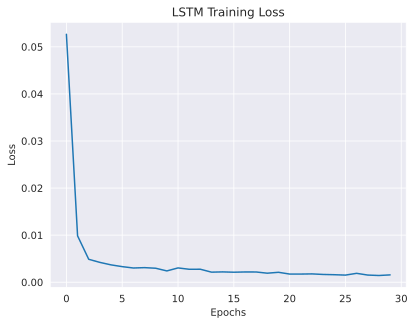

In [1084]:
sns.lineplot(x=range(epochs), y=lstm_losses)
plt.title("LSTM Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [1147]:
gru_lookback = 36
hidden_size = 10
num_layers = 3
gru_best = MyGRU(1, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(gru_best.parameters(), lr=0.005)

train_gru_x, train_gru_y = create_lookback_dataset(train, gru_lookback)
train_gru_x = torch.from_numpy(train_gru_x).type(torch.float32)
train_gru_y = torch.from_numpy(train_gru_y).type(torch.float32)

gru_loader = DataLoader(TensorDataset(train_gru_x, train_gru_y), batch_size=4, shuffle=True)

In [1148]:
epochs = 30
gru_losses = []

for _ in range(epochs):
    loss_ = 0.0
    for (x, y) in gru_loader:
        optimizer.zero_grad()
        output = gru_best.forward(x)
        loss = criterion(output, y)
        loss.backward()
        loss_ += loss.item()
        optimizer.step()
    gru_losses.append(loss_ / len(gru_loader))

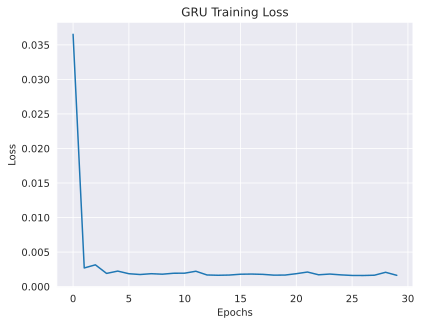

In [1149]:
sns.lineplot(x=range(epochs), y=gru_losses)
plt.title("GRU Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Additional models

#### Statistical models

In [1049]:
open_price_df = df[['Date', 'Open']].loc[:len(train)-1]
open_price_df = open_price_df.rename(columns={'Date': 'ds', 'Open': 'y'})
open_price_df["unique_id"] = 0
open_price_df.head()

,ds,y,unique_id
0,2022-01-07,314.149994,0
1,2022-01-10,309.489990,0
2,2022-01-11,313.380005,0
3,2022-01-12,319.670013,0
4,2022-01-13,320.470001,0


In [1050]:
sf = StatsForecast(
    models = [
        AutoARIMA(max_P=10, max_Q=10, max_p=10, max_q=10, max_d=10, max_D=10, max_order=10),
        AutoRegressive(lags=5),
        TBATS(seasonal_periods=1),
        AutoTheta(),
        HistoricAverage(),
        Holt()
    ],
    freq = "D",
    n_jobs=-1
)

sf.fit(open_price_df)
preds = sf.predict(h=len(test), level=[95])

In [1051]:
preds = preds[["ds", "AutoARIMA", "AutoRegressive", "AutoTheta", "HistoricAverage", "Holt", "TBATS"]]

### LSTM and GRU prediction

In [1150]:
lstm_test = np.concatenate([train[-lstm_lookback:], test])
lstm_test_x, lstm_test_y = create_lookback_dataset(lstm_test, lstm_lookback)

lstm_test_x = torch.from_numpy(lstm_test_x).type(torch.float32)

In [1151]:
gru_test = np.concatenate([train[-gru_lookback:], test])
gru_test_x, gru_test_y = create_lookback_dataset(gru_test, gru_lookback)

gru_test_x = torch.from_numpy(gru_test_x).type(torch.float32)

In [1152]:
with torch.no_grad():
    lstm_preds = best_lstm.forward(lstm_test_x).detach().numpy()
    gru_preds = gru_best.forward(gru_test_x).detach().numpy()

In [1153]:
stats_pred = preds.drop("ds", axis=1).assign(time=range(len(preds))).melt(id_vars="time", value_name="prediction", var_name="model")
lstm_preds_inversed = scaler.inverse_transform(lstm_preds).flatten()
gru_preds_inversed = scaler.inverse_transform(gru_preds).flatten()
prices_inversed = scaler.inverse_transform(test.reshape(-1, 1)).flatten()

### Comparisons

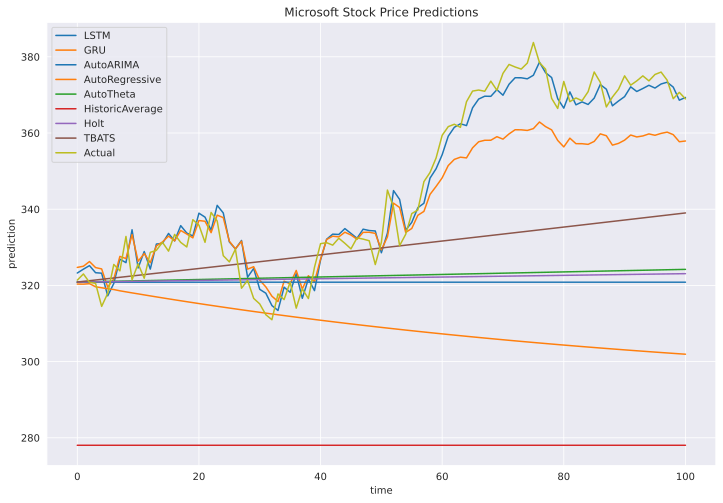

In [1154]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=range(len(lstm_preds)), y=lstm_preds_inversed, label="LSTM")
sns.lineplot(x=range(len(gru_preds)), y=gru_preds_inversed, label="GRU")
sns.lineplot(data=stats_pred, x="time", y="prediction", hue="model")
sns.lineplot(x=range(len(prices_inversed)), y=prices_inversed.flatten(), label="Actual")
plt.title("Microsoft Stock Price Predictions")
plt.show()

In [1155]:
all_preds = preds.copy().drop("ds", axis=1)
all_preds["LSTM"] = lstm_preds_inversed
all_preds["GRU"] = gru_preds_inversed

In [1156]:
all_preds

,AutoARIMA,AutoRegressive,AutoTheta,HistoricAverage,Holt,TBATS,LSTM,GRU
unique_id,,,,,,,,
0,320.837219,320.354858,320.877655,278.031769,320.862518,320.887054,323.254486,324.721313
0,320.837219,320.328094,320.910950,278.031769,320.884705,321.063477,324.260559,325.032532
0,320.837219,320.457367,320.944244,278.031769,320.906891,321.239990,325.192017,326.262085
0,320.837219,319.634491,320.977539,278.031769,320.929077,321.416595,323.330750,324.677551
0,320.837219,319.380554,321.010834,278.031769,320.951233,321.593323,323.205994,324.329193
...,...,...,...,...,...,...,...,...
0,320.837219,302.379517,324.073944,278.031769,322.991638,338.273254,372.870361,359.899841
0,320.837219,302.267120,324.107239,278.031769,323.013824,338.459229,373.335358,360.234863
0,320.837219,302.155853,324.140533,278.031769,323.035980,338.645294,372.049347,359.568024


In [1157]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

In [1158]:
mae_res = all_preds.apply(lambda x: mae(x, prices_inversed), axis=0)
mape_res = all_preds.apply(lambda x: mape(x, prices_inversed), axis=0)
rmse_res = all_preds.apply(lambda x: rmse(x, prices_inversed), axis=0)

In [1159]:
df = pd.DataFrame([mae_res, mape_res, rmse_res], index=["MAE", "MAPE", "RMSE"]).T
df.style.apply(lambda x: ["background: red" if v == x.min() else "" for v in x], axis=0)

,MAE,MAPE,RMSE
AutoARIMA,26.206313,0.081681,33.842403
AutoRegressive,36.266923,0.118497,45.397633
AutoTheta,24.770752,0.076632,32.016960
HistoricAverage,67.823677,0.243942,71.550316
Holt,25.247978,0.078303,32.625868
TBATS,18.785674,0.056341,24.323175
LSTM,3.791145,0.011086,4.753645
GRU,8.110500,0.023241,9.885441
